## Project Proposal: US Citizens 

### Introduction

TEST FOR CHANGES

For our project, we have decided on a fairly straightforward topic. With given information about a person, we want to predict whether their income is greater than or equal to $50,000. This information may include their education, age, occupation, etc.

We will be using the **Adult** dataset taken from https://archive.ics.uci.edu/dataset/2/adult, which is based on a census done in 1994. There are 32560 rows in the data with each observation representing a single person and their various attributes. There are 15 columns each representing a different part of the person. The columns are:
 - age
 - workclass: self-employed, private, etc.
 - fnlwgt: final weight
 - education: the highest level of education achieved
 - education-num: the highest level of education achieved (numerical)
 - marital-status: married, single, etc.
 - occupation: general type of occupation (sales, services, etc.)
 - relationship: wife, husband, own-child, etc.
 - race: White, Black, Asian, etc.
 - sex: biological sex (Male, Female)
 - capital-gain: 
 - capital-loss
 - hours-per-week: hours at work each week
 - native-country: country of origin
 - income: <=50k, >50k

### Preliminary Data Analysis

In [3]:
# Loading libraries
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [7]:
# Reading downloaded csv file
adult <- read_csv("data/adult.csv")

# Adding column names
colnames(adult) <- c('age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                     'marital_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')
slice(adult, 1:4)

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age workclass        fnlwgt education education_num marital_status    
1 50  Self-emp-not-inc  83311 Bachelors 13            Married-civ-spouse
2 38  Private          215646 HS-grad    9            Divorced          
3 53  Private          234721 11th       7            Married-civ-spouse
4 28  Private          338409 Bachelors 13            Married-civ-spouse
  occupation        relationship  race  sex    capital_gain capital_loss
1 Exec-managerial   Husband       White Male   0            0           
2 Handlers-cleaners Not-in-family White Male   0            0           
3 Handlers-cleaners Husband       Black Male   0            0           
4 Prof-specialty    Wife          Black Female 0            0           
  hours_per_week native_country income
1 13             United-States  <=50K 
2 40             United-States  <=50K 
3 40             United-States  <=50K 
4 40             Cuba           <=50K

In [10]:
# Filtered out the general age of when someone graduates and retires (22 - 65)
# Filtered out the general hours a fully employed person would work in a week (35 - 45)

filtered_adult <- adult |> 
    filter(age >= 22, age <= 65) |>
    filter(hours_per_week >= 35, hours_per_week <= 45)

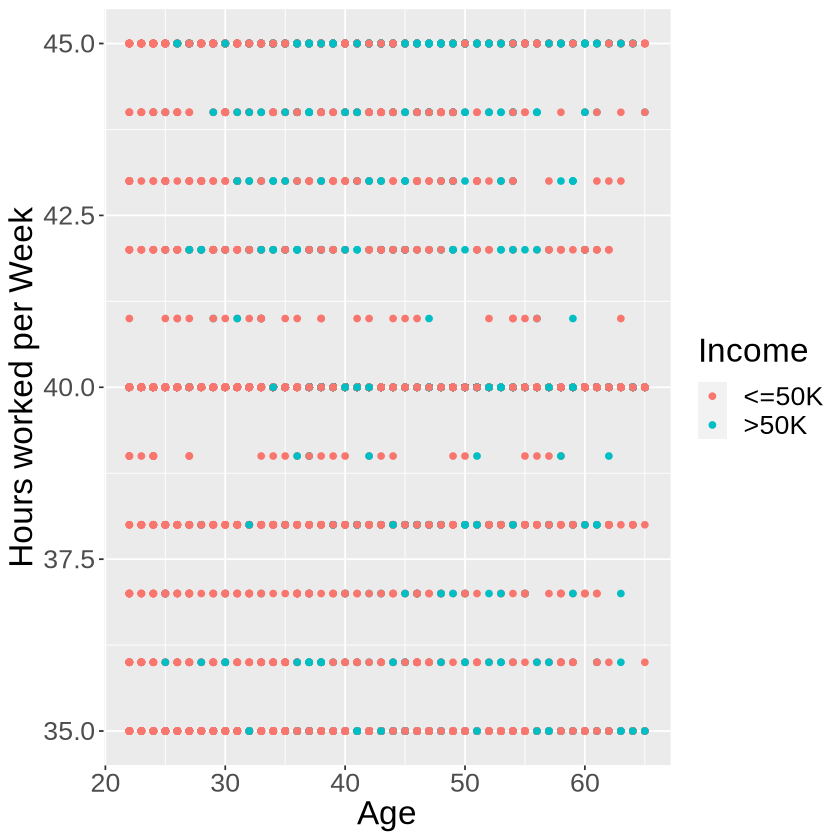

In [20]:
# Scatter plot of Age vs Hours Per Week

age_vs_hrs <- filtered_adult |>
    ggplot(aes(x = age, y = hours_per_week)) +
    geom_point(aes(colour = income)) +
    labs(x = "Age", y = "Hours worked per Week", colour = "Income") +
    theme(text = element_text(size = 20))

age_vs_hrs

In [71]:
# Many of the predictors are categorical so we need to convert them into numerical values
adult_numerical <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    mutate(across(workclass:native_country, as.factor)) |>
    sapply(unclass) 
adult_final <- adult |>
    select(age, fnlwgt, education_num, capital_gain, capital_loss, hours_per_week, income)
adult_final <- cbind(adult_final, adult_numerical) |>
    mutate(income = as_factor(income))

# Getting the training data
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
adult_split <- initial_split(adult_final, prop = 0.75, strata = income)  
adult_train <- training(adult_split)   
adult_test <- testing(adult_split)

In [72]:
# Beginning data analysis:
# We will take the mean of our numerical predictors and the mode of our categorical predictors

analysis_mean <- adult_train |>
    select(age, fnlwgt, capital_gain, capital_loss, hours_per_week) |>
    map_df(mean, na.rm = TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

analysis_mode <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    map_df(getmode)

# Mean value of our numerical predictors
analysis_mean
# Most frequent value of our categorical predictors 
analysis_mode

age      fnlwgt   capital_gain capital_loss hours_per_week
1 38.60363 189183.4 1136.137     88.29805     40.44252

workclass education marital_status     occupation     relationship race  sex 
1 Private   HS-grad   Married-civ-spouse Prof-specialty Husband      White Male
  native_country
1 United-States

### Methods

Our question is a classification problem so we want to use the K nearest neighbors model in tidymodels. Since we converted all columns to numerical we can use any column as a predictor. We want to use the majority of the columns available as predictors because most of them are fairly relevant to income. But there are some variables that we don't want to use or make some changes to:
1. The relationship and marital_status columns are redundant so we can just use marital_status.
2. Workclass is not very relevant to income so we will not use it as a predictor.
3. Marital status contains information on whether they are married to a civilian or military. This isn't important to income so we can simply convert all values to just "married."